### Initialize notebook

In [6]:
#!/home/akhanal1/Spring2018/pl-env/bin/python3.5
# Torch imports
import copy
import os
import sys
sys.path.append('/home/ak/PycharmProjects/ature')
os.chdir('/home/ak/PycharmProjects/ature')

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import PIL.Image as IMG
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import classification_report
from neuralnet.utils.weights_utils import initialize_weights

import matplotlib.pyplot as plt
import numpy as np

from commons.segmentation import AtureTest
from commons.IMAGE import SegmentedImage


from utils import img_utils as imgutil
from commons.IMAGE import Image
from neuralnet.unet.unet_trainer import UNetNNTrainer
from neuralnet.unet.hrf_dataloader import PatchesGenerator, PatchesGeneratorPerImgObj
import neuralnet.utils.measurements as mnt
import neuralnet.utils.data_utils as nndutils
from neuralnet.unet.model.unet import UNet

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
### Define folders. Create if needed.
sep = os.sep
Dirs = {}
Dirs['checkpoint']   = 'assests' +sep+ 'nnet_models'
Dirs['data']      = 'data'+sep+'HRF'+sep+'training'
Dirs['images']    = Dirs['data'] +sep+ 'images'
Dirs['mask']      = Dirs['data'] +sep+ 'mask'
Dirs['truth']     = Dirs['data'] +sep+ 'manual1'

TestDirs = {}
TestDirs['data']      = 'data'+sep+'HRF'+sep+'testing'
TestDirs['images']    = TestDirs['data'] +sep+ 'images'
TestDirs['mask']      = TestDirs['data'] +sep+ 'mask'
TestDirs['truth']     = TestDirs['data'] +sep+ 'manual1'

ValidationDirs = {}
ValidationDirs['data']      = 'data'+sep+'DRIVE'+sep+'testing'
ValidationDirs['images']    = ValidationDirs['data'] +sep+ 'validation_images'
ValidationDirs['mask']      = ValidationDirs['data'] +sep+ 'mask'
ValidationDirs['truth']     = ValidationDirs['data'] +sep+ 'manual1'

for k, folder in Dirs.items():
    os.makedirs(folder, exist_ok=True)
for k, folder in TestDirs.items():
    os.makedirs(folder, exist_ok=True)
for k, folder in ValidationDirs.items():
    os.makedirs(folder, exist_ok=True)

def get_mask_file(file_name): 
    return file_name.split('.')[0] + '_mask.tif'

def get_ground_truth_file(file_name): 
    return file_name.split('.')[0] + '.tif'

num_channels =1
classes = { 'background': 0, 'vessel': 1,}
batch_size = 2
num_classes = len(classes)
epochs = 20
patch_rows, patch_cols = 388, 388 #height by width of training patches
use_gpu = False

#### Images to train/validate per epoch , None means USE ALL data####
train_size = None 
validation_size = None
checkpoint_file = 'PytorchCheckpointUnetMirroredHRFImages.nn.tar'

### Transformations

In [8]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

### Load train data

In [ ]:
trainset = PatchesGenerator(Dirs=Dirs, train_image_size=(patch_rows, patch_cols), 
                                 transform=transform,
                                 fget_mask=get_mask_file, 
                                 fget_truth=get_ground_truth_file, mode='train') 

train_size = trainset.__len__() if train_size is None else train_size
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=False, num_workers=0, 
                                          sampler=WeightedRandomSampler(np.ones(trainset.__len__()), train_size))

### Load Validation Data

In [ ]:
validation_set = PatchesGenerator(Dirs=ValidationDirs, train_image_size=(patch_rows, patch_cols),  
                                       transform=transform,
                                       fget_mask=get_mask_file_test, 
                                       fget_truth=get_ground_truth_file, mode='train') 

validation_size = validation_set.__len__() if validation_size is None else validation_size
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, 
                                            shuffle=False, num_workers=0,
                                            sampler=WeightedRandomSampler(np.ones(validation_set.__len__()), 
                                                                          validation_size, replacement=True))

### Define the network

In [ ]:
net = UNet(num_channels, num_classes)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

### Train and evaluate network

In [ ]:
trainer = UNetNNTrainer(model=net, checkpoint_dir=Dirs['checkpoint'], checkpoint_file=checkpoint_file, 
                          to_tensorboard=False)
# trainer.resume_from_checkpoint()
trainer.train(optimizer=optimizer, dataloader=trainloader, epochs=epochs, use_gpu=use_gpu, 
              validationloader=validationloader, force_checkpoint=False, log_frequency=20)

### Test on a image

In [35]:
img_obj = SegmentedImage()
img_obj.load_file(data_dir=Dirs['images'], file_name='01_dr.JPG')
img_obj.load_mask(mask_dir=Dirs['mask'], fget_mask=get_mask_file, erode=True)
img_obj.load_ground_truth(gt_dir=Dirs['truth'], fget_ground_truth=get_ground_truth_file)

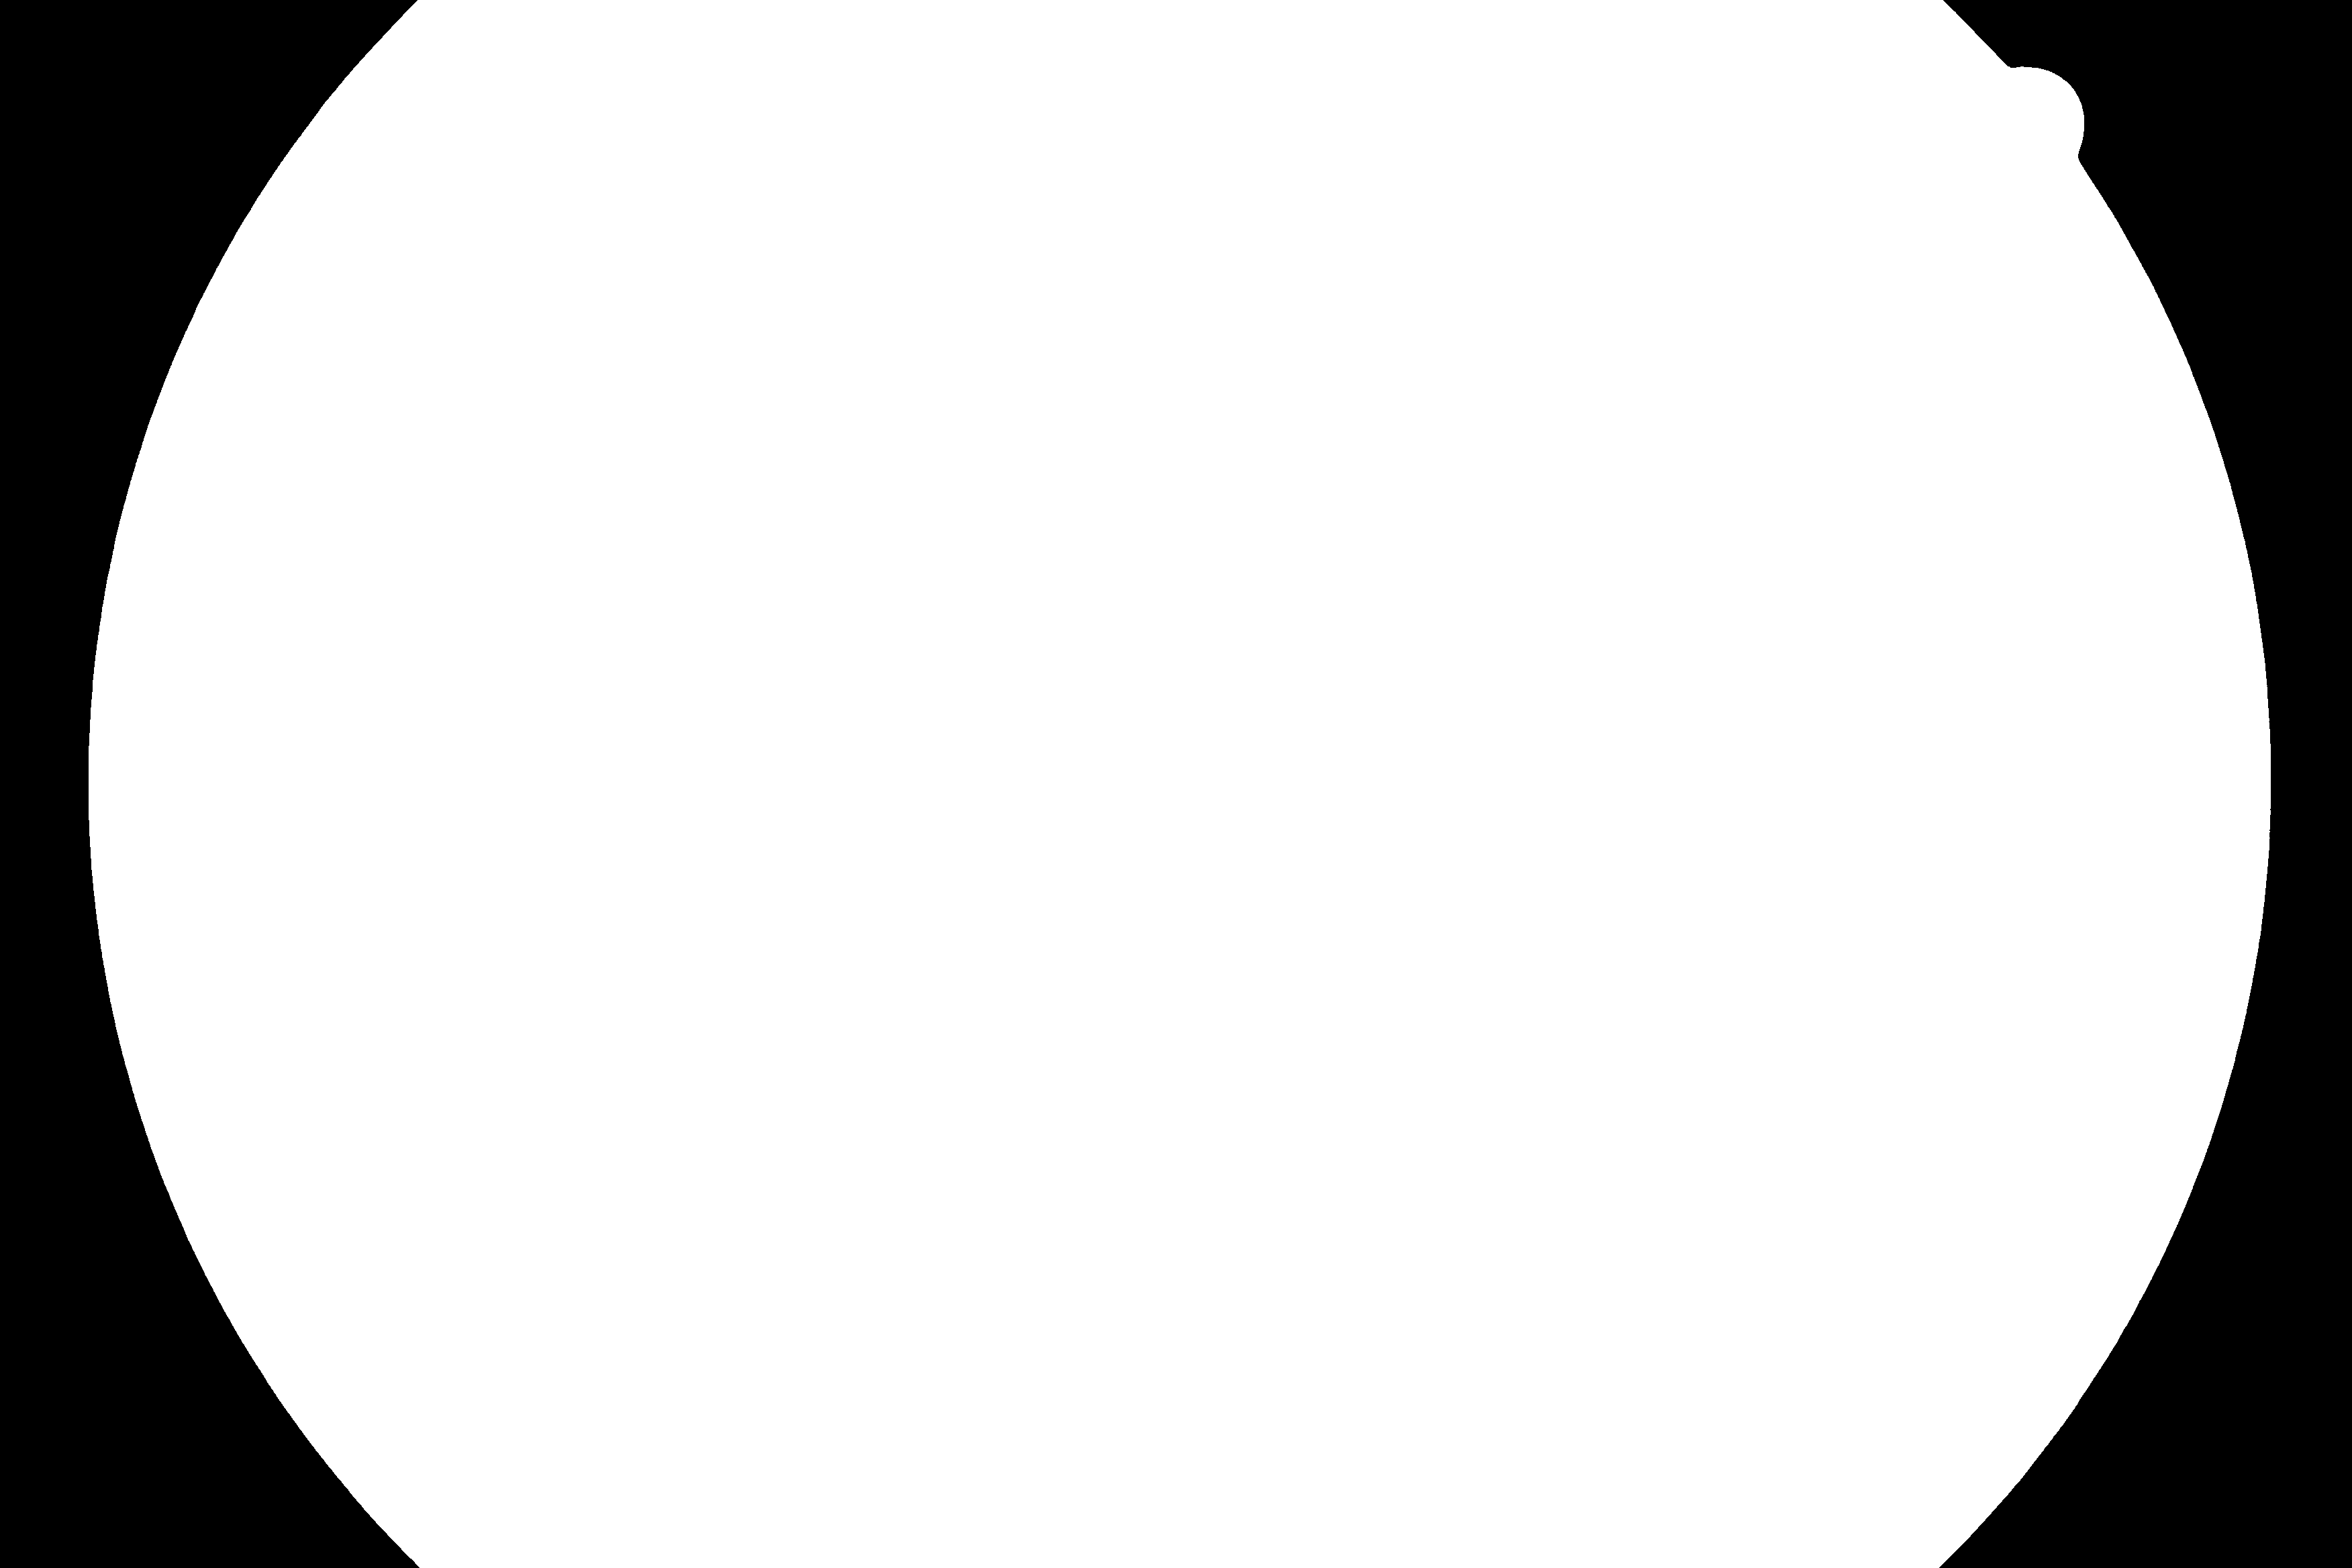

In [25]:
IMG.fromarray(img_obj.mask)

In [39]:
transform_test = transforms.Compose([
        imgutil.whiten_image2d,
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

testset = PatchesGeneratorPerImgObj(img_obj=img_obj, train_image_size=(patch_rows, patch_cols), 
                                    transform=transform_test) 

testloader = torch.utils.data.DataLoader(testset, batch_size=1, 
                                          shuffle=False, num_workers=0, sampler=WeightedRandomSampler(np.ones(testset.__len__()), 
                                                                          1, replacement=True))

### 0 patches found.
### 70 patches found.


In [40]:
scores, y_pred, y_true = trainer.evaluate(dataloader=testloader, use_gpu=use_gpu, force_checkpoint=False)
# mnt.plot_confusion_matrix(y_pred=y_pred, y_true=y_true, classes=classes)


Evaluating...
Batch[1/1] pre:0.600 rec:0.495 f1:0.543 acc:0.921


In [43]:
s = np.exp(scores[:, 1, :, :]) * 255

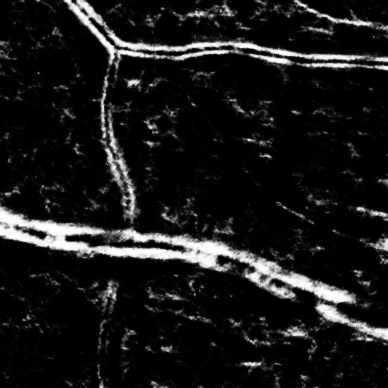

In [45]:
IMG.fromarray(np.array(s.squeeze(), dtype=np.uint8) )

### Merge the output to form a single image

In [44]:
import neuralnet.unet.utils as ut

In [45]:
ppp = ut.merge_patches(scores, img_obj.working_arr.shape, (patch_rows, patch_cols))

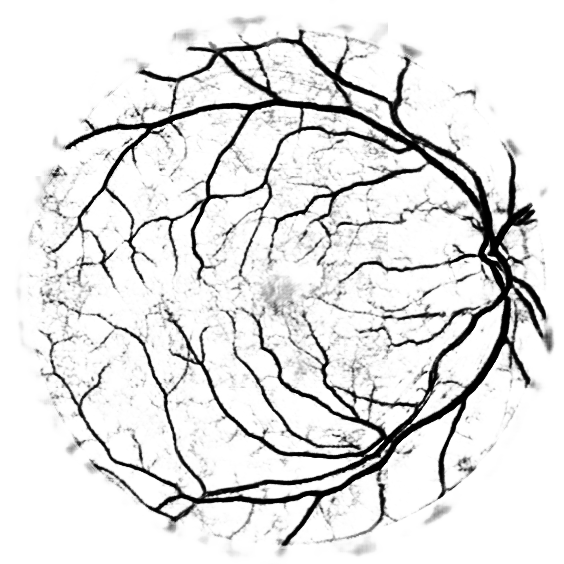

In [46]:
IMG.fromarray(ppp)

### FAST MST algorithm

In [ ]:
params = {'sk_threshold': 150,
          'alpha': 7.0,
          'orig_contrib': 0.3,
          'seg_threshold': 24}

img_obj.working_arr = None #todo
img_obj.generate_skeleton(threshold=params['sk_threshold'])
img_obj.generate_lattice_graph()

In [27]:
for x,i in enumerate(testloader):
    break

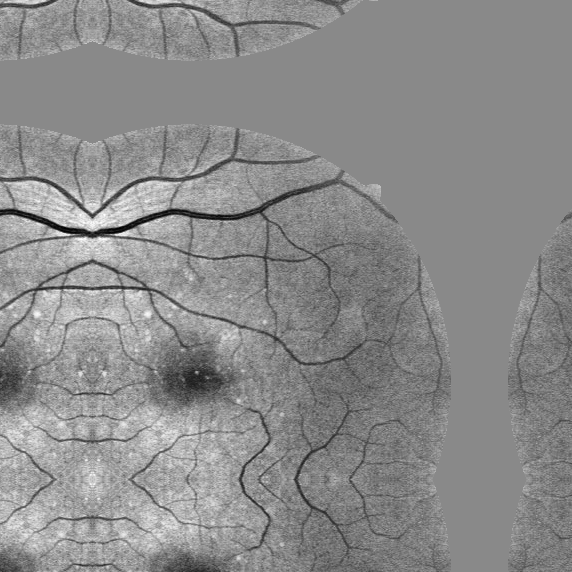

In [28]:
IMG.fromarray(np.array(i[0][1].squeeze()*255, dtype=np.uint8))

In [29]:
np.array(i[0].squeeze()*255, dtype=np.uint8).shape

(4, 572, 572)